# Introduction 

This notebook was authored by Will Chapman (wchapman@ucar.edu) but was inspired by a lot of machine learning lectures and tutorials. I have credited everything I pulled from below. Please email me if you have any questions!


# A guide to this notebook.
 
In this tutorial we will cover: Stochastic Gradient Descent from scratch, loss functions, overfitting, the bias-variance tradeoff, and regularization

1.   How do machines/algorithms "learn" and what is loss?
1.   How do we validate machine learning models?: Overfitting
2.   How do we improve machine learning models?: Bias-Variance Tradeoff + Regularization

These topics offer rich examples of **developing intuition**, and these topics have **specific applicability to machine learning in climate** problems.





## Start by importing some simple packages




- Pieces of this tutorial are inspired by many authors. Here is the credit (alot of the code/jokes are directly lifted):  

    - Sol Kim (AGU ML tutorial)
    - Will Chapman (AGU ML tutorial) 
    - Ankur Mahesh (AGU ML Tutorial)
    - Dan Jurafsky (Stanford CS124)
    - Erik Bekkers (U. Amsterdam)

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

## Why Machine Learning?

Chihua or muffin?  

This is a seminal problem in our field!  

![alt text](https://cdn-media-1.freecodecamp.org/images/1*bt-E2YcPafjiPbZFDMMmNQ.jpeg)

# Machine Learning Fundamentals

In this section, we will cover some of the fundamentals of machine learning!  We will refer to chapters from Professor Jonathan Shewchuk's excellent lecture notes from CS189 (UC Berkeley's Machine Learning class) as well as course notes developed by TAs including Garrett Thomas and Soroush Nasiriany. These notes provide a rigorous mathematical basis of the foundations of machine learning, and they are very helpful for developing the intuition behind tackling machine learning problems.  If you are interested in going deeper into machine learning, I strongly recommend reading these two resources.

*   Dr. Shewchuk's lecture notes can be found at this [link ](https://people.eecs.berkeley.edu/~jrs/papers/machlearn.pdf)
*   Nasiriany and Thomas's course notes can be found at this [link ](http://snasiriany.me/files/ml-book.pdf)

Furthermore, a very useful experiment in machine learning is implementing ML models (decision trees, random forests, logistic regression) from scratch!  While packages such as sklearn have models readily available for you to use, the best learning experience is to implement the models to develop an intuition of what is going on "under the hood."

# The fundamentals of optimizing / fitting a line (sorry to some of you!)

![slide0](slide0.png )

![alt text](slide1.png "Current IRI Enso Forecast")


![alt text](slide2.png "Current IRI Enso Forecast")


![alt text](slide3.png "Current IRI Enso Forecast")


![alt text](slide4.png "Current IRI Enso Forecast")


![alt text](slide5.png "Current IRI Enso Forecast")


![alt text](slide7.png "Current IRI Enso Forecast")


In [2]:
#first just generate some synthetic data with noise: 
#play with this to change the fit!!! 
def synthetic_data(w, b, num_examples,unlearnable_noise=4):  
    """
    Generate synthetic data for a linear regression problem.

    Parameters:
    - w (numpy.ndarray): The weight vector representing the coefficients of the linear model.
    - b (float): The intercept term in the linear model.
    - num_examples (int): The number of data points to generate.
    - unlearnable_noise (float): The standard deviation of unlearnable noise to add to the target values.

    Returns:
    - X (numpy.ndarray): The feature matrix of shape (num_examples, len(w)).
    - y (numpy.ndarray): The target values of shape (num_examples, 1).

    This function generates synthetic data for a linear regression problem. It creates 'num_examples'
    data points with features 'X' and corresponding target values 'y' based on the linear model
    'y = Xw + b', with the addition of random noise.

    The feature matrix 'X' is generated with random values from a standard normal distribution.
    The target values 'y' are computed by taking the dot product of 'X' and 'w', adding the intercept 'b',
    and introducing random noise with a standard deviation of 'unlearnable_noise'.

    Example usage:
    w = np.array([2.0, -3.0])
    b = 4.0
    num_examples = 100
    X, y = synthetic_data(w, b, num_examples)
    """
    X = np.random.normal(0, 1, (num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(0, unlearnable_noise, y.shape)
    return X, y.reshape((-1, 1))

def data_iter(batch_size, features, labels):
    """
    Generate minibatches of data for training.

    Parameters:
    - batch_size (int): The size of each minibatch.
    - features (numpy.ndarray): The feature matrix of shape (num_examples, num_features).
    - labels (numpy.ndarray): The corresponding target values of shape (num_examples, 1).

    Yields:
    - X_batch (numpy.ndarray): A minibatch of features with shape (batch_size, num_features).
    - y_batch (numpy.ndarray): A minibatch of target values with shape (batch_size, 1).

    This function is an iterator that generates minibatches of data for training. It shuffles
    the examples at random and returns minibatches of 'batch_size' examples at each iteration.

    Example usage:
    batch_size = 32
    features, labels = load_training_data()
    for X_batch, y_batch in data_iter(batch_size, features, labels):
        # Training loop: process each minibatch
        train_model(X_batch, y_batch)
    """
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = np.array(
            indices[i: min(i + batch_size, num_examples)])
        return features[batch_indices], labels[batch_indices]
        
def linreg(X, w, b):  #@save
    """The linear regression model."""
    return np.dot(X, w) + b

def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return np.sum((y_hat - y) ** 2)/len(y_hat)


def data_iter(batch_size, features, labels):

    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = np.array(
            indices[i: min(i + batch_size, num_examples)])
        return features[batch_indices], labels[batch_indices]

# Let's take a second and look at this next bit of code

In [251]:
def sgd_regressor_linear(X, y, learning_rate=0.2, n_epochs=1000, k=100):
    """
    Stochastic Gradient Descent (SGD) Regression.

    Parameters:
    - X (numpy.ndarray): The feature matrix of shape (m, n), where m is the number of data points
      and n is the number of features.
    - y (numpy.ndarray): The target values of shape (m, 1).
    - learning_rate (float): The learning rate for gradient descent. Default is 0.2.
    - n_epochs (int): The number of epochs (iterations) for training. Default is 1000.
    - k (int): The batch size for each iteration. Default is 100.

    Returns:
    - w (numpy.ndarray): The learned weight vector of shape (1, n).
    - b (numpy.ndarray): The learned intercept value.

    This function performs Stochastic Gradient Descent (SGD) to train a linear regression model.
    It minimizes the squared loss between the predicted values and the actual target values.

    The algorithm iteratively updates the model parameters 'w' (weights) and 'b' (intercept) using
    mini-batches of the data. In each epoch, it computes gradients for the loss with respect to
    'w' and 'b' using a batch of 'k' data points and updates them accordingly. The process continues
    for 'n_epochs' iterations.

    The learning rate is automatically reduced by 1.02 after each epoch to help convergence.

    During training, the loss is printed for each epoch.

    Note: Make sure you have the 'data_iter' and 'squared_loss' functions defined before using this function.

    Example usage:
    w, b = sgd_regressor(X_train, y_train, learning_rate=0.1, n_epochs=1000, k=50)
    """
    
    w = np.random.randn(1,X.shape[1])  # Randomly initializing weights
    b = np.random.randn(1,1)           # Random intercept value
    
    epoch=1
    loss_tot = []
    while epoch <= n_epochs: #how many times should we sample the data when we learn ?????? 
        X_tr,y_tr = data_iter(k,X, y) #(~batch)

        Lw = w #init the partial derivative terms 
        Lb = b #init the partial derivative terms 
        
        loss = 0
        y_pred = []
        sq_loss = []
                
        for i in range(len(X_tr)):
              
            Lw = (-2/k * X_tr[i]) * (y_tr[i] - np.dot(X_tr[i],w.T) - b) #partial derivatives of our weight terms (averaged by number of samples k)
            Lb = (-2/k) * (y_tr[i] - np.dot(X_tr[i],w.T) - b) #partial derivatives of our intercept term (averaged by number of samples k)
            
            w = w - learning_rate * Lw # change the weight by the derivative
            b = b - learning_rate * Lb # gradients of our intercept term
            
            y_predicted = np.dot(X_tr[i],w.T)
            y_pred.append(y_predicted)
        
        loss = squared_loss(np.array(y_pred), np.array(y_tr))
        loss_tot.append(loss)
        print("Epoch: %d, MSE Loss: %.3f" %(epoch, loss))
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print("Learned Weights (w):", w[0])
        print("Learned Intercept (b):", b[0])
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        epoch+=1
        learning_rate = learning_rate/1.02 #systematically lower the learning rate.... 
        
    return w,b,loss_tot

## Stochastic Gradient Descent (SGD) Regression and Visualization

Epoch: 1, MSE Loss: 459.189
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Learned Weights (w): [-0.459783   -1.12326095  0.29741933  3.70535987]
Learned Intercept (b): [-0.43956554]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Epoch: 2, MSE Loss: 309.495
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Learned Weights (w): [-0.04973745 -1.98003707  1.20931968  6.93747905]
Learned Intercept (b): [0.70350098]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Epoch: 3, MSE Loss: 209.528
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Learned Weights (w): [ 0.03008011 -2.29228429  1.8693731   9.68480659]
Learned Intercept (b): [1.32347537]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Epoch: 4, MSE Loss: 149.440
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Learned Weights (w): [ 0.47726903 -2.76910177  2.53056634 11.81686178]
Learned Intercept (b): [1.8403658]
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Epoch: 5, MSE Loss: 95.708
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Learned Weights (w): [ 0.58241767 -3.0215347   2.91471867 13.32719955]
Learned Intercept (b

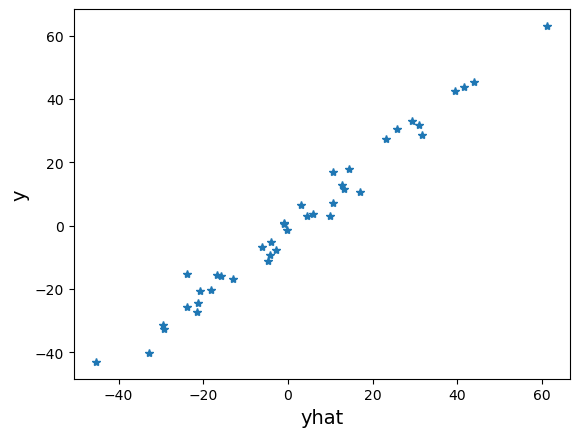

Learned Weights (w): [ 1.65641612 -3.48176542  4.6506427  19.82897387]
True Weights (w): [array([ 2. , -3.4,  5. , 20. ])]
Learned Intercept (b): [3.94602537]
True Intercept (b): [[4.2]]


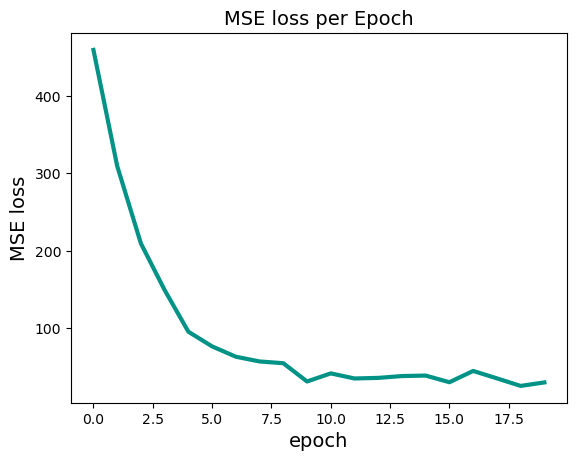

In [383]:
%matplotlib inline
## #call the data generator
true_w = np.array([2, -3.4, 5, 20])  # this is what we are trying to learn!!! 
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000, unlearnable_noise=4)
## #call the data gen

# Train the SGD regressor with the given features and labels for 20 epochs and a learning rate of 0.1
w, b,loss_tot = sgd_regressor_linear(features, labels, n_epochs=20, learning_rate=0.1)

# Make predictions using the trained model
prediction = linreg(features, w.T, b)

# Create a scatter plot to visualize the first 40 predicted values and actual labels
plt.figure()
plt.plot(prediction[:40], labels[:40], '*')
plt.xlabel('yhat',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.show()

# Print the learned weights 'w' and intercept 'b' from the SGD regression
print("Learned Weights (w):", w[0])
print("True Weights (w):", [true_w])
print("Learned Intercept (b):", b[0])
print("True Intercept (b):", [[true_b]])

plt.figure()
plt.plot(loss_tot,linewidth=3,color='xkcd:teal')
plt.title('MSE loss per Epoch',fontsize=14)
plt.ylabel('MSE loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.show()

## Think About the Learning Rate and the Error Gradient Field:

In [45]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
x_poly = np.linspace(-100,100,81)
print(x_poly[:5],'....',x_poly[-5:])
def cost_function(X):
    return 2*X**2-4*X
def gradient(X):
    return  (4*X) -4
y_poly = cost_function(x_poly)
x_start=85
from ipywidgets import interactive
def gdsct(iterations,learning_rate):
    x_path = np.empty(iterations)
    x_path[0] = x_start
    for i in range (1,len(x_path)):
        derivative =gradient(x_path[i-1])
        x_path[i] = x_path[i-1]-(derivative*learning_rate)
    plt.figure()
    plt.plot(x_poly,y_poly,color='xkcd:teal',linewidth=3)
    plt.plot(x_path,cost_function(x_path),'-o',color='xkcd:purple')
    plt.ylabel('ERROR gradient Field',fontsize=13)
    plt.xlabel('parameter value',fontsize=14)
    plt.show()
interactive_plot = widgets.interact(gdsct,iterations = (1,30),learning_rate= (0.01,.45,.005))
interactive_plot

[-100.   -97.5  -95.   -92.5  -90. ] .... [ 90.   92.5  95.   97.5 100. ]


interactive(children=(IntSlider(value=15, description='iterations', max=30, min=1), FloatSlider(value=0.23, de…

<function __main__.gdsct(iterations, learning_rate)>

<img src="https://royalsocietypublishing.org/cms/asset/88555317-5290-4cbd-9370-93c2e0f17abe/rsta20180145f03.jpg" width="500">
- credit:  Big data: the end of the scientific method? Sauro Succi and Peter V. Coveney


## Section about Fitting MSE linear model: Linear Model (Analytical Solution & Stochastic Gradient Descent [SGD])
 - hit loss functions

![alt text](slide8.png)
![alt text](slide10.png)
![alt text](slide11.png)


## Section about Fitting a Categorical Problem: Logisitic Regression (SGD)

![alt text](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*DJl92cVaYxb93y4Y0dqBPw.png)
[photo credit](https://srnghn.medium.com/machine-learning-trying-to-predict-a-categorical-outcome-6ba542b854f5)

https://www.youtube.com/watch?v=gPab8n1QK1M



- for logisitic regression the solution is Convex (we are guaranteed to find the minimum starting at any point).
- for Deep learning this is not the case! 

## For a full Description of Simple Discrimenators + MATH: 

- https://www.youtube.com/watch?v=IQJTlUvATbs&list=PL8FnQMH2k7jzhtVYbKmvrMyXDYMmgjj_n&index=32

- https://www.youtube.com/watch?v=HKU9Mp__rYg&list=PL8FnQMH2k7jzhtVYbKmvrMyXDYMmgjj_n&index=33

- https://www.youtube.com/watch?v=nMrGFegAPd0

![smf](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*a04iKNbchayCAJ7-0QlesA.png)

![alt text](slide9.png)


### Playlist to understand maximizing likelihood and categorical cross entropy: 
 - 0. Basics using Bernoulli trials: [post here](https://pub.towardsai.net/how-did-binary-cross-entropy-loss-come-into-existence-68e38509d2b)
 
More Entropy based arguments:
 - 1. Watch this on KL divergence: [video here](https://www.youtube.com/watch?v=SxGYPqCgJWM)
 - 2. Watch this on cross entropy loss [video here](https://www.youtube.com/watch?v=Pwgpl9mKars)
 - 3. This video does a good summarizing the above two topics (entropy) [video here](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)
 - 4. To derive the gradient terms of logistic regression [video here](https://www.youtube.com/watch?v=nMrGFegAPd0&t=5s)
 - 5. OR read this post [post here](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)

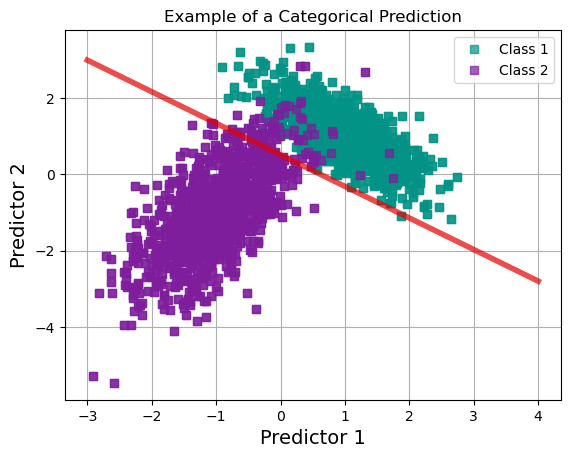

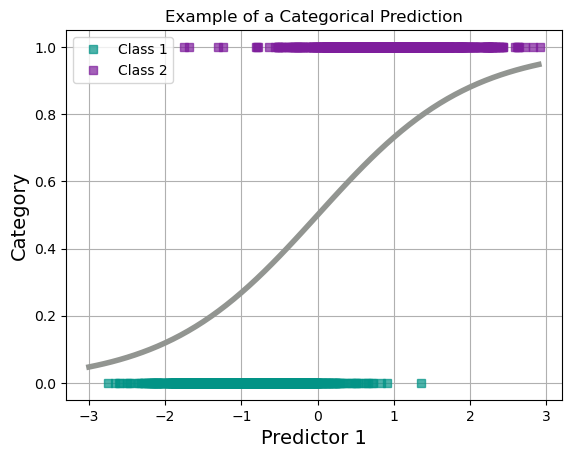

In [422]:
X, y = make_classification(n_samples=2000,n_features=2, n_redundant=0, 
                           n_informative=2, random_state=123, 
                           n_clusters_per_class=1)

plt.plot(X[np.where(y==0),0][0],X[np.where(y==0),1][0],'s',color='xkcd:teal',alpha=0.7,label='Class 1')
plt.plot(X[np.where(y==1),0][0],X[np.where(y==1),1][0],'s',color='xkcd:purple',alpha=0.7,label='Class 2')
plt.plot(X[np.where(y==0),0],X[np.where(y==0),1],'s',color='xkcd:teal',alpha=0.7)
plt.plot(X[np.where(y==1),0],X[np.where(y==1),1],'s',color='xkcd:purple',alpha=0.7)
plt.plot([-3,4],[3,-2.8],linewidth=4,color='xkcd:red',alpha=0.7)

plt.ylabel('Predictor 2',fontsize=14)
plt.xlabel('Predictor 1',fontsize=14)
plt.grid(True)
plt.legend()
plt.title('Example of a Categorical Prediction')
plt.show()


plt.plot(-1*X[np.where(y==0),0].squeeze(),y[np.where(y==0)],'s',color='xkcd:teal',alpha=0.7,label='Class 1')
plt.plot(-1*X[np.where(y==1),0].squeeze(),y[np.where(y==1)],'s',color='xkcd:purple',alpha=0.7,label='Class 2')
plt.plot(np.arange(-3,3,.1),1/(1+np.exp(-np.arange(-3,3,.1))),linewidth=4,color='xkcd:grey')
plt.ylabel('Category',fontsize=14)
plt.xlabel('Predictor 1',fontsize=14)
plt.grid(True)
plt.legend()
plt.title('Example of a Categorical Prediction')
plt.show()

In [1]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def accuracy(y_pred, y_test):
    return np.sum(y_pred==y_test)/len(y_test)

![smf](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*a04iKNbchayCAJ7-0QlesA.png)

## Logistic Regression Functions



In [444]:
def sgd_regressor_logistic(X, y, learning_rate=0.01, n_epochs=1000, k=100):
    """
    Stochastic Gradient Descent (SGD) Logistic Regression.

    Parameters:
    - X (numpy.ndarray): The feature matrix of shape (m, n), where m is the number of data points
      and n is the number of features.
    - y (numpy.ndarray): The target values of shape (m, 1).
    - learning_rate (float): The learning rate for gradient descent. Default is 0.2.
    - n_epochs (int): The number of epochs (iterations) for training. Default is 1000.
    - k (int): The batch size for each iteration. Default is 100.

    Returns:
    - w (numpy.ndarray): The learned weight vector of shape (1, n).
    - b (numpy.ndarray): The learned intercept value.
    - loss_tot (list): accuracy by epoch 

    This function performs Stochastic Gradient Descent (SGD) to train a logistic regression model.
    It minimizes the log loss (cross-entropy) between the predicted probabilities and the actual binary labels.

    The algorithm iteratively updates the model parameters 'w' (weights) and 'b' (intercept) using
    mini-batches of the data. In each epoch, it computes gradients for the log loss with respect to
    'w' and 'b' using a batch of 'k' data points and updates them accordingly. The process continues
    for 'n_epochs' iterations.

    The learning rate is automatically reduced by 1.02 after each epoch to help convergence.

    During training, the accuracy is printed for each epoch.

    Note: Make sure you have the 'data_iter' and 'sigmoid' functions defined before using this function.

    Example usage:
    w, b, acc_loss = sgd_regressor_logistic(X_train, y_train, learning_rate=0.1, n_epochs=1000, k=50)
    """
    
    w = np.random.randn(X.shape[1])  # Randomly initializing weights
    b = 0   # Random intercept value

    epoch=1
    loss_tot = [0] #init accuracy.
    while epoch <= n_epochs: #how many times should we sample the data when we learn (~epochs)? 
        
        X_tr,y_tr = data_iter(k,X,y)  #get a random sampling of your test data K points long (~batch)
        
                
        #predictions (actual logistic regression) and weight update:
        linear_pred = np.dot(X_tr, w) + b
        predictions = sigmoid(linear_pred)
        
        dw = (1/k) * np.dot(X_tr.T, (predictions - y_tr))
        db = (1/k) * np.sum(predictions-y_tr)
        
        w = w - learning_rate*dw # change the weight by the derivative
        b = b - learning_rate*db # gradients of our intercept term
        
        
        ###accuracy testing on training data:
        linear_pred = np.dot(X_tr, w) + b
        predictions = sigmoid(linear_pred)
        class_pred = [0 if y<=0.5 else 1 for y in predictions]
        acc = accuracy(class_pred, y_tr)
            

        loss_tot.append(acc)
        if epoch%20==0:
            print("Epoch: %d, accuracy: %.3f" %(epoch, acc))
        epoch+=1
        learning_rate = learning_rate/1.02 #systematically lower the learning rate.... 
        
    return w,b,loss_tot

## Make the predictions

Epoch: 20, accuracy: 0.797
Epoch: 40, accuracy: 0.870
Epoch: 60, accuracy: 0.870
Epoch: 80, accuracy: 0.940
Epoch: 100, accuracy: 0.933
Epoch: 120, accuracy: 0.930
Epoch: 140, accuracy: 0.903
Epoch: 160, accuracy: 0.920
Epoch: 180, accuracy: 0.923
Epoch: 200, accuracy: 0.943
Epoch: 220, accuracy: 0.927
Epoch: 240, accuracy: 0.913


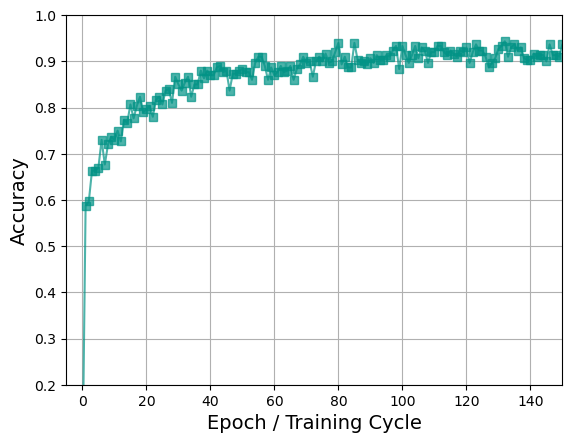

In [445]:
########################################
#produce the data: 
########################################
X, y = make_classification(n_samples=2000,n_features=30, n_redundant=0, 
                           n_informative=7, random_state=123, 
                           n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
########################################
########################################

################################
#train your model [get the weights and bias term]
################################
w,b,loss_tot = sgd_regressor_logistic(X_train, y_train, learning_rate=0.1, n_epochs=250, k=300) #play with hyper params
################################

################################
#this is your learned model:
################################
linear_pred = np.dot(X_test, w.T) + b
predictions = sigmoid(linear_pred).squeeze()
class_pred = [0 if y<=0.5 else 1 for y in predictions] #hyperparamter
################################
################################

######################################
###### How good is your model? #######
accuracy(class_pred, y_test)
######################################


######################################
###### Plot the training cycle #######
plt.figure()
plt.plot(loss_tot,color='xkcd:teal',marker='s',alpha=0.7)
plt.ylabel('Accuracy',fontsize=14)
plt.xlabel('Epoch / Training Cycle',fontsize=14)
plt.grid(True)
plt.ylim([0.2,1])
plt.xlim([-5,150])
plt.show()
######################################
######################################



## Throughout the remainder of this notebook, we will cover two topics (and we will use the SKLEARN API, shown in Charlie's lecture):
 overfitting, the bias-variance tradeoff, and machine 

1.   How do we validate machine learning models?: Overfitting
2.   How do we improve machine learning models?: Bias-Variance Tradeoff


These topics offer rich examples of **developing intuition**, and these topics have **specific applicability to machine learning in climate** problems.


## The Train/Val/Test Set and Overfitting

A machine learning model uses statistical optimization to learn the relationship between predictors (the input) and predictands (the target).  
*   At this workshop, our predictors have been anomalized global temperature, and our predictand has been the El Nino/ Southern Oscillation (ENSO) 3.4 Index at a lead time.  

Let's call our predictors $X$, and let's call our predictand $y$.  There is some unknown relationship between $X$ and $y$.  For example, there is some unknown function governing the relationship between global temperature and the future ENSO index.  The goal of an ML model is to *approximate* this unknown function.

How do we test if the ML model has correctly approximated this function?  We divide the data into a train set and a test set.


*   During training, the ML model is shown the predictors and their associated predictands.  The ML model uses optimization to learn a function: given the training predictors, the function outputs the predictands as closely as possible.
*   During testing, the ML model is evaluated on unseen data (i.e. the test set). When a model performs well on the training set and poorly on the test, the model has **overfit** to the train set.
*   If a model performs poorly on the training set, this behavior is called **underfitting**.  During underfitting, the model has not learned the correct relationship between the predictors and the predictand.

## ***POLL QUESTION:*** In the image below, which image corresponds to overfitting? Which corresponds to underfitting? And which corresponds to neither?


![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)




## Useful Loading/Plotting Functions:

In [3]:
#Scaffold code to load in data.  This code cell is mostly data wrangling
#Feel free to peruse at your leisure.

def load_enso_indices():
    """
    Reads in the txt data file to output a pandas Series of ENSO vals

    outputs
    -------

    pd.Series : monthly ENSO values starting from 1870-01-01
    """
    with open('nino34.long.anom.data.txt') as f:
        line = f.readline()
        enso_vals = []
        while line:
            yearly_enso_vals = map(float, line.split()[1:])
            enso_vals.extend(yearly_enso_vals)
            line = f.readline()

    enso_vals = pd.Series(enso_vals)
    enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
    enso_vals.index = pd.to_datetime(enso_vals.index)
    return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time, 
                                    use_pca=False, n_components=32):
    """
    inputs
    ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date 
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      use_pca          bool : whether or not to apply principal components
                              analysis to the sst field
      n_components      int : the number of components to use for PCA

    outputs
    -------
      Returns a tuple of the predictors (np array of sst temperature anomalies) 
      and the predictands (np array the ENSO index at the specified lead time).

    """
    ds = xr.open_dataset('../../0_data/sst.mon.mean.trefadj.anom.1880to2018.nc')
    sst = ds['sst'].sel(time=slice(start_date, end_date))
    num_time_steps = sst.shape[0]
  
    #sst is a 3D array: (time_steps, lat, lon)
    #in this tutorial, we will not be using ML models that take
    #advantage of the spatial nature of global temperature
    #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    #(At each time step, there are lat*lon predictors)
    sst = sst.values.reshape(num_time_steps, -1)
    sst[np.isnan(sst)] = 0

    #Use Principal Components Analysis, also called
    #Empirical Orthogonal Functions, to reduce the
    #dimensionality of the array
    if use_pca:
        pca = sklearn.decomposition.PCA(n_components=n_components)
        pca.fit(sst)
        X = pca.transform(sst)
    else:
        X = sst

    start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
    end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
    y = load_enso_indices()[slice(start_date_plus_lead, 
                                end_date_plus_lead)]

    ds.close()
    return X, y

def plot_nino_time_series(y, predictions, title):
    """
    inputs
    ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

    outputs
    -------
    None.  Displays the plot
    """
    predictions = pd.Series(predictions, index=y.index)
    predictions = predictions.sort_index()
    y = y.sort_index()

    plt.plot(y, label='Ground Truth',color='xkcd:teal')
    plt.plot(predictions, '--', label='ML Predictions',color='xkcd:purple')
    plt.legend(loc='best')
    plt.title(title)
    plt.ylabel('Nino3.4 Index')
    plt.xlabel('Date')
    plt.show()
    plt.close()


#Data We Will Use in this Tutorial: 
---


## Data Set 1:  Nino 3.4 prediction from global SSTs


ENSO 1998![ENSO1998](https://drive.google.com/uc?id=1xWRCICvpskmpOSwWWz78GRmCsO3Twdym
)

### Dataset Description: 
Nino3.4 index time series from the [NCAR Climate Gateway](https://www.earthsystemgrid.org/) and Monthly SST Anomalies from the [Cobe V2. dataset](https://www.esrl.noaa.gov/psd/data/gridded/data.cobe2.html)


**Nino3.4** is a time series of sea surface temperature [SST] anomalies averaged in the tropical pacific (lat [5N-5S], lon [170W-120W]). The index typically consists of a 5- month running mean SST field

The **Cobe V2.** data set is a 1.0 degree latitude x 1.0 degree longitude global grid (180x360) resolution sea surface tempearture field which spans latitude: 89.5N - 89.5S, and longitude: 0.5E - 359.5E. is analysis, a daily SST field is constructed as a sum of a trend, interannual variations, and daily changes, using in situ SST and sea ice concentration observations. 

### Task: 

A neural network is tasked with identifying whether a sea-surface temperature (SST) pattern is characteristic of a positive (El Nino) or negative (La Nina) phase of the El Nino Southern Oscillation (ENSO).


The code cell below **demonstrates overfitting**: getting great performance on the train set.
For an absurd lead time (36 months!!), it is possible to get a perfect correlation on the train set.  Such accurate forecasting at such large lead times is almost certainly impossible.

In [7]:
%matplotlib inline

#Load in the predictors
X, y = assemble_predictors_predictands('1990-01-01','2005-12-31', 36)

#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X,y)

predictions = regr.predict(X)
corr, _ = scipy.stats.pearsonr(predictions, y)

plot_nino_time_series(y, predictions, 
    'Predicted and True Nino3.4 Indices on Training Set at 36 Month Lead Time. \n Corr: {:.2f}'.format(corr))

##### The cell above shows that getting great train-set performance is possible, even for a very tough task (36 month ahead Nino forecast).
We need to evaluate the model on unseen data to see if it can **generalize** well: this is why a test set is so crucial!


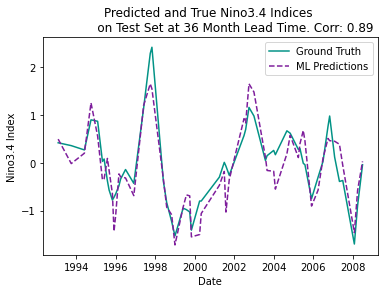

In [241]:
"""Evaluate the model on a randomly selected test set"""
#X has shape (num_time_steps, lat*lon)
#y has shape (num_time_steps)
np.random.seed(0)

#Randomly shuffle X and y to split them in a train and test set
num_time_steps = X.shape[0]
permuted_indices = np.random.permutation(np.arange(num_time_steps))

#Keep 70% of the data for the test set
train_set_proportion = int(0.7 * num_time_steps)
X, y = X[permuted_indices], y[permuted_indices]
X_train, y_train = X[:train_set_proportion], y[:train_set_proportion]
X_test, y_test = X[train_set_proportion:], y[train_set_proportion:]

#Instead of writing the above logic yourself, sklearn also provides
#a built-in method in the line below.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

## WHOA?! What happened above? Did we just develop a 36-month ahead forecast that has 0.89 correlation on unseen data?? 

![alt text](model-predictions-of-ens.png "Current IRI Enso Forecast")


#### Randomly splitting time series data into a train set and a test set is very risky. In many climate datasets, time series have a non-neglible auto-correlation.  Think of it like this: the atmosphere usually has a "memory" of about 14 days, and the ocean roughly has a "memory" of about 2 years.  

If we randomly split the dataset into train set and test set, some of the examples in the test set will be correlated with examples in the train set.  **This corrupts our test set.** If the test set is correlated with the train set, then it no longer measures how generalizable our ML model is.

**CODING EXERCISE** In the cell below, write code to evaluate the model on a true uncorrelated test set.

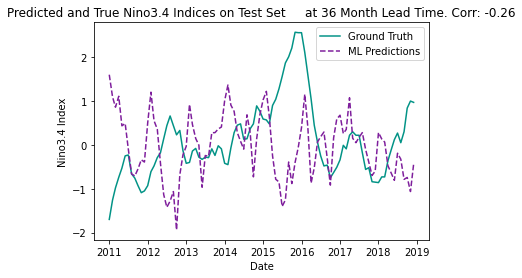

In [242]:
"""YOUR CODE HERE"""
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31',36)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

#### This makes more sense.  On a true test set, our model making *36 month ahead* predictions does not generalize well.

***CODING EXERCISE*** Using the code samples above as a starting point, in the following cell, write code to calculate and plot the performance of the model at different lead times.

100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


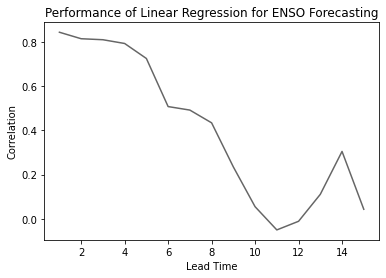

In [243]:
"""YOUR CODE HERE"""
"""Plot the performance of linear regression-based ENSO forecasting at
different lead times"""
#the keys of the dictionary are the lead time, and the values are the 
#correlation between linear regression forecasts and the truth
lead_time_to_corr_dict = {}

#tqdm handles showing the progress bar
for lead_time in tqdm(range(1,16,1)):
    X_train, y_train = assemble_predictors_predictands('1990-01-01','2005-12-31',
                                                     lead_time)
    X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 
                                                 lead_time)

    regr = sklearn.linear_model.LinearRegression()
    regr.fit(X_train,y_train)

    predictions_test = regr.predict(X_test)
    corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
    lead_time_to_corr_dict[lead_time] = corr

plt.plot(list(lead_time_to_corr_dict.keys()), 
         list(lead_time_to_corr_dict.values()),color='k',alpha=0.6)
plt.title('Performance of Linear Regression for ENSO Forecasting')
plt.xlabel('Lead Time')
plt.ylabel('Correlation')
plt.show()

# Bias Variance Trade-Off

### Introduction and Theory

The behavior of machine learning models can be decomposed into two quantities:

*   **Bias**: On the training set, how well does the machine learning model predict the truth?
*   **Variance**: As the input data varies, how does the machine learning prediction vary?  For a small change in the input predictors, how much would the ML prediction change? 

Let's look at the earlier figure once again:
![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)


The left image uses a linear model to approximate a nonlinear "true function".  Therefore, the linear model does not understand the function well, and it has high bias.  Similarly, it has low variance, because small changes to sample points along the curve will not change the linear model must.


***Polling question*** 
1. Does the right image have high or low bias?
2. Does the right image have high or low variance?


Based on the figures above, we conclude that bias and variance are often a tradeoff: models with high bias often have low variance, and vice versa.  See page 23 of Nasiriany's notes for a mathematical derivation of this tradeoff.


#### Let's connect the bias/variance tradeoff to the discussion we had on overfitting in the first section. Implications of the bias-variance tradeoff (from Wikipedia)

"The bias error is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting)."

"The variance is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting)."

## Regularization

Our goal in machine learning is to avoid underfitting and overfitting: we want to develop models that perform well in both the train set and the test set.

One method to avoid overfitting is **regularization.** In the next section, we will discuss how regularization avoids overfitting.  

Let $X$ be a 2D matrix of shape $(n,d)$ where $n$ is the number of time steps and $d$ is the number of predictors.  Let $y$ be a vector of shape $(n,1)$ that has the target ENSO values.  Let $w$ be a vector of shape $(d,1)$

In ordinary least squares linear regression, we are **finding the value of $w$** that minimizes the following term: 

$$\text{min}||Xw-y||^2 $$


Here's an intuitive description of the math above: 
*   the goal of linear regression is to minimize the squared difference between the linear models' predictions ($Xw$) and the truth ($y$).

The forecast of a linear regression model is $Xw$.  Here's an intuitive description of what $Xw$: 
*   a linear regression model makes a forecast by multiplying each predictor by its associated weight and returning the sum of these products. With  large weights, a small change in one of the predictors will lead to a large change in the forecast.  Therefore, we amend linear regression to penalize the model from learning large weights:


$$\text{min}||Xw-y||^2 + \alpha ||w||^2 $$


$\alpha ||w||^2$ is called a regularization term. This regularized form of linear regression is often called **Ridge Regression**.

Please see pg. 6 of Nasiriany for mathematical derivations to the solutions of the above two minimization problems.


### *Coding Problem*: Regularization


In this example, we will investigate the real-world effect of regularization on our ENSO dataset. 

Note: for visualization purposes, we do not train our models using all lat$*$lon predictors.  Instead, we use Principal Components Analysis (aka Empirical Orthogonal Functionals) to represent all lat$*$lon predictors with far fewer dimensions.  Due to time constraints, please refer to page 116 of Professor Shewchuk's notes for a deeper explanation of this method.

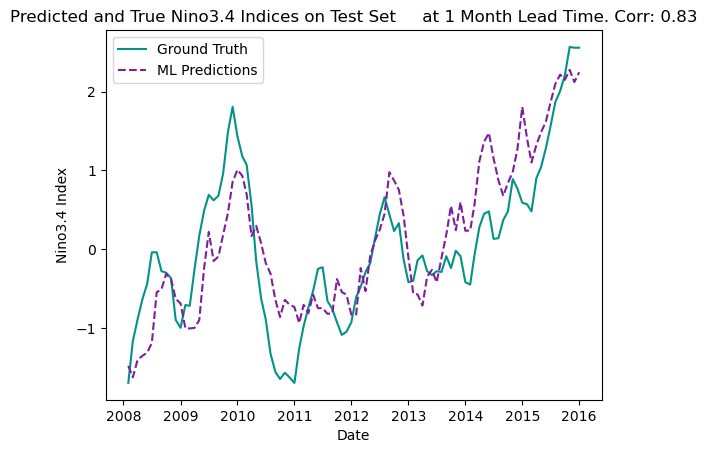

In [39]:
X_train, y_train = assemble_predictors_predictands('1990-01-01','2005-12-31', 
                                                1,use_pca=True)
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


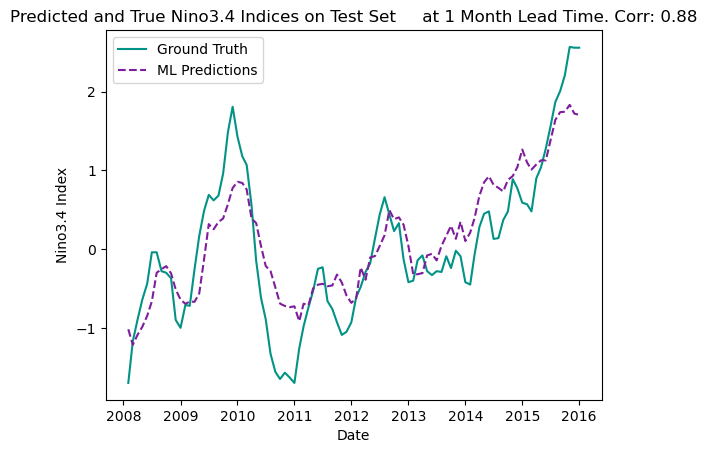

In [40]:
X_train, y_train = assemble_predictors_predictands('1990-01-01','2005-12-31', 
                                                1,use_pca=True)
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_ridge = sklearn.linear_model.Ridge(alpha=80000.0)
regr_1_month_ridge.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_ridge.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


## WOOHOO! Right off the bat, on the test set we see that the regularized model performs slightly better than the linear model! This is a good sign, as the goal of regularization is to develop models that can better **generalize** to unseen data.

Next, let's visualize and compare the variance of the two models.  Recall that models that are highly variable are susceptable to small fluctuations in the predictors.  In the code cell below, we conduct the experiment:


*   Perturb the test set predictors by multiplying them by a random number between -1.05 and 1.05
*   Run the trained ridge regression and linear regression models on those perturbed predictors
*   Record the spread in the predictions

The spread of these predictions is the variance of the ML model.

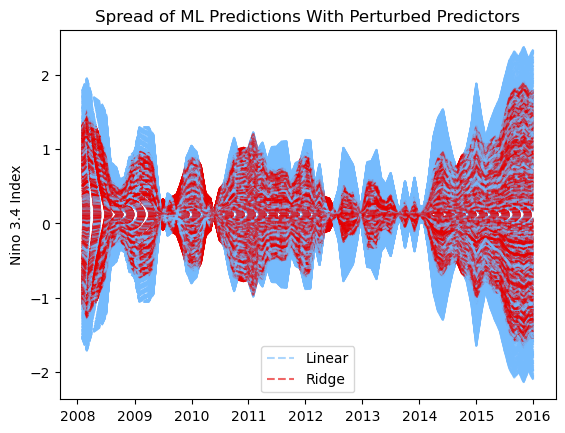

In [42]:
"""In this cell, we will visualize the variance of linear regression and ridge regression"""
for experiment_num in range(1000):
    perturbed_X_test = X_test * np.random.uniform(-1.05,1.05)
  
    perturbed_predictions_linear = regr_1_month_lr.predict(perturbed_X_test)
    perturbed_predictions_linear = pd.Series(perturbed_predictions_linear,
                                           index=y_test.index)
    plt.plot(perturbed_predictions_linear, '--', label='Linear', color='xkcd:sky blue',
           alpha=0.6)

    perturbed_predictions_ridge = regr_1_month_ridge.predict(perturbed_X_test)
    perturbed_predictions_ridge = pd.Series(perturbed_predictions_ridge,
                                           index=y_test.index)
    plt.plot(perturbed_predictions_ridge, '--', label='Ridge', color='xkcd:red',
           alpha=0.6)

    if experiment_num == 0: plt.legend(loc='best')

plt.title("Spread of ML Predictions With Perturbed Predictors")
plt.ylabel("Nino 3.4 Index")
plt.show()

##### The plot above illustrates the effect of regularization!  When randomly perturbing the input 1000 times, the predictions from linear regression (blue) have a larger spread than those from ridge regression (orange).  This means that linear regression has a higher variance than ridge regression.  



##### In the cell below, let's investigate why ridge regression is less vulnerable to small fluctuations in the data.

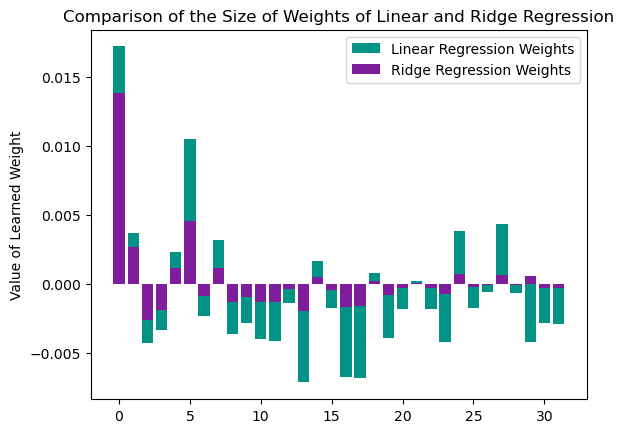

In [44]:
"""In this cell, we will visualize how the weights of the linear 
regression model are bigger than those of the ridge regression model"""

regr_1_month_lr_weights = regr_1_month_lr.coef_
regr_1_month_ridge_weights = regr_1_month_ridge.coef_

plt.bar(range(regr_1_month_lr_weights.shape[0]), regr_1_month_lr_weights,
        label='Linear Regression Weights',color='xkcd:teal')
plt.bar(range(regr_1_month_ridge_weights.shape[0]), regr_1_month_ridge_weights,
        label='Ridge Regression Weights',color='xkcd:purple')
plt.legend(loc='best')
plt.ylabel('Value of Learned Weight')
plt.title('Comparison of the Size of Weights of Linear and Ridge Regression')
plt.show()

## Optional Section We might skip:

### Potpourri Polling Project 1: Variance Scaling

In the preprocessing presentation, we discussed ways that data is normalized before being fed into machine learning models.  Some models ML techniques require data to be centered (have mean 0); in other cases, normalization helps with numerical stability.  

One type of normalization is called variance scaling.  Variance scaling is to scale the variance of each predictor such that each predictor has a variance of 1.  

In our ENSO dataset, we have latxlon predictors; each predictor is temperature at a certain location on Earth.  We have ```num_time_steps``` samples of these predictors. Therefore, the shape of ```X``` is (num_time_steps, latxlon). *Variance scaling would mean that we scale our dataset such that the variance of temperature at each grid cell is 1.*

**Polling Question:** should we use variance scaling for our ENSO forecasting model?

In [ ]:
"""Plot the linear regression predictions when the input data has been variance
scaled"""
X_train, y_train = assemble_predictors_predictands('1980-01-01','2005-12-31', 
                                                2)
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 2)

#StandardScaler(with_mean=False) learns a transformation that scales
#the data such that its standard deviation is 1. Setting
#with_mean to True also centers the data so that it has mean 0. Try it out!
scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)

#IMPORTANT: Note that the test data must be completely unseen! Therefore, we cannot
#use it to learn how to scale data; we cannot scale the train and test 
#data at once.  That would corrupt our test dataset, as the train dataset
#would be scaled based on properties from the test dataset.
#Instead, we use a variance scaling transformation on the training set, 
#and apply that same transformation to the test set.
X_test = scaler.transform(X_test)

#1 month linear regression (lr) model
regr_1_month_lr_var_scale = sklearn.linear_model.LinearRegression()
regr_1_month_lr_var_scale.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr_var_scale.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set with Variance Scaling\
    at 2 Month Lead Time. Corr: {:.2f}'.format(corr))

In [ ]:
"""Plot the linear regression predictions when the input data has not been variance
scaled"""
X_train, y_train = assemble_predictors_predictands('1980-01-01','2005-12-31', 2)
X_test, y_test = assemble_predictors_predictands('2008-01-01','2015-12-31', 2)

#1 month linear regression (lr) model
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set without Variance Scaling\
    at 2 Month Lead Time. Corr: {:.2f}'.format(corr))

What's going on here? Why does variance scaling adversely affect performance?

Here is a *theory* about why this is happening: our predictors correspond to real temperature at latitude/ longitude grid cells.  Grid cells with constant latitude and longitude are of very different sizes! 1 degree x 1 degree at the poles is much smaller than 1 degree x 1 degree at the equator. Therefore, grid cells closer to the poles are more noisier and have more variance.  This is important for an ENSO forecasting model to take into account!  If we scale variance, the larger grid cells lose their comparative advantage in predictive power to smaller grid cells, and the machine learning model does worse.

This example illustrates how to tackle problems at the ***intersection*** of machine learning and climate.  We must use intuition and theory of both fields to pose experiments and analyze results.

Do you have any other ideas? I'd be very curious to hear them!!

In [ ]:
"""Plot the variance of SST anomalies at each grid cell"""

ds = xr.open_dataset('../../0_data/sst.mon.mean.trefadj.anom.1880to2018.nc')
sst = ds['sst'].sel(time=slice("1980-01-01","2005-12-31"))
sst_var = sst.std(axis=0)**2

sst_var.plot()


## We have treated El Nino like a Regression Problem What if we use our Classifying Skills? 

**CODING EXERCISE** In the cell below, write code to turn ENSO prediction into a classification problem and try to solve it with Logistic Regression at various lead times. Explore the SKlearn API and try out different algorithms.

- what kind of model would you use? 
- solve it! 

In [1]:
"""YOUR CODE HERE"""
"""Plot the performance of linear regression-based ENSO forecasting at
different lead times"""
_, y = assemble_predictors_predictands('1990-01-01','2005-12-31',1)
y_el_nino_binary = (y > 0.5).rolling(window=5).min()
y_la_nina_binary = (y < 0.5).rolling(window=5).min()
y_classification = pd.Series(np.zeros(y_el_nino_binary.shape),
                     index=y.index)
y_classification[y_el_nino_binary == 1.0] = 2 
y_classification[y_la_nina_binary == 1.0] = 1  